# Tutorial 2: Integrating all 12 DLPFC slices
This tutorial demonstrates STAligner's ablility to integrate 12 slices from three adult samples with four adjacent slices for each. The slices are sampled from human dorsolateral prefrontal cortex (DLPFC) and the processed data can be downloaded from https://drive.google.com/drive/folders/1pHJy2cB9BKqc3ny9IpvVhiw_8ukJMzPW?usp=share_link.

## Preparation

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import STAligner

# the location of R (used for the mclust clustering)
import os
os.environ['R_HOME'] = "/users/jyao/.conda/envs/proust-310/lib/R"
os.environ['R_USER'] = "/users/jyao/.conda/envs/STAligner/lib/python3.9/site-packages/rpy2"
import rpy2.robjects as robjects
import rpy2.robjects.numpy2ri


import anndata as ad
import scanpy as sc
import pandas as pd
import numpy as np
import scipy.sparse as sp
import scipy.linalg

import torch
used_device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## Load Data

In [5]:
Batch_list = []
adj_list = []
section_ids = ['151673', '151674', '151675', '151676',
               '151507', '151508', '151509', '151510',
               '151669', '151670','151671', '151672']
print(section_ids)

for section_id in section_ids:
    print(section_id)
    input_dir = '/dcs04/hicks/data/jianing/datasets/proust_datasets/spatialDLPFC/' + str(section_id)
    adata = sc.read_visium(path=input_dir, count_file='filtered_feature_bc_matrix.h5', load_images=True)
    adata.var_names_make_unique(join="++")    

    # read the annotation
    df_meta = pd.read_csv(input_dir + '/metadata.tsv', sep='\t')
    df_meta_layer = df_meta['layer_guess']
    adata.obs['ground_truth'] = df_meta_layer.values
    adata.obs['ground_truth'] = adata.obs['ground_truth'].astype('category')

    # make spot name unique
    adata.obs_names = [x + '_' + section_id for x in adata.obs_names]
    STAligner.Cal_Spatial_Net(adata, rad_cutoff=150)

    ## Normalization
    sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=10000) #ensure enough common HVGs in the combined matrix
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    adata = adata[:, adata.var['highly_variable']]
    adj_list.append(adata.uns['adj'])
    Batch_list.append(adata)

['151673', '151674', '151675', '151676', '151507', '151508', '151509', '151510', '151669', '151670', '151671', '151672']
151673
------Calculating spatial graph...
The graph contains 21124 edges, 3639 cells.
5.8049 neighbors per cell on average.
151674
------Calculating spatial graph...
The graph contains 21258 edges, 3673 cells.
5.7876 neighbors per cell on average.
151675
------Calculating spatial graph...
The graph contains 20762 edges, 3592 cells.
5.7801 neighbors per cell on average.
151676
------Calculating spatial graph...
The graph contains 20052 edges, 3460 cells.
5.7954 neighbors per cell on average.
151507
------Calculating spatial graph...
The graph contains 24770 edges, 4226 cells.
5.8613 neighbors per cell on average.
151508
------Calculating spatial graph...
The graph contains 25698 edges, 4384 cells.
5.8618 neighbors per cell on average.
151509
------Calculating spatial graph...
The graph contains 28172 edges, 4789 cells.
5.8826 neighbors per cell on average.
151510
----

## Concat the scanpy objects for multiple slices

In [15]:
adata_concat = ad.concat(Batch_list, label="slice_name", keys=section_ids)
adata_concat.obs['ground_truth'] = adata_concat.obs['ground_truth'].astype('category')
adata_concat.obs["batch_name"] = adata_concat.obs["slice_name"].astype('category')
print('adata_concat.shape: ', adata_concat.shape)

# combine silce names into sample name
new_batch_1 = adata_concat.obs["slice_name"].isin(['151673', '151674', '151675', '151676'])
new_batch_2 = adata_concat.obs["slice_name"].isin(['151507', '151508', '151509', '151510'])
new_batch_3 = adata_concat.obs["slice_name"].isin(['151669', '151670', '151671', '151672'])
adata_concat.obs["sample_name"] = list(sum(new_batch_1)*['Sample 1'])+list(sum(new_batch_2)*['Sample 2'])+list(sum(new_batch_3)*['Sample 3'])
adata_concat.obs["sample_name"] = adata_concat.obs["sample_name"].astype('category')
adata_concat.obs["batch_name"] = adata_concat.obs["sample_name"].copy()

adata_concat.shape:  (47681, 800)


## Concat the spatial network for multiple slices

In [16]:
adj_concat = np.asarray(adj_list[0].todense())
for batch_id in range(1,len(section_ids)):
    adj_concat = scipy.linalg.block_diag(adj_concat, np.asarray(adj_list[batch_id].todense()))
adata_concat.uns['edgeList'] = np.nonzero(adj_concat)

## Running STAligner

In [18]:
%%time
# Important parameter:
# "iter_comb" is used to specify the order of integration
# "margin" is used to control the intensity/weight of batch correction
adata_concat = STAligner.train_STAligner(adata_concat, iter_comb = None, verbose=True, device=used_device, margin=1.0)

STAligner(
  (conv1): GATConv(800, 512, heads=1)
  (conv2): GATConv(512, 30, heads=1)
  (conv3): GATConv(30, 512, heads=1)
  (conv4): GATConv(512, 800, heads=1)
)
Pretrain with STAGATE...


100%|██████████████████████████████████████████████████████████████████████████████| 500/500 [00:25<00:00, 19.27it/s]


Train with STAligner...


  0%|                                                                                        | 0/500 [00:00<?, ?it/s]

Update spot triplets at epoch 500


 20%|███████████████▋                                                               | 99/500 [00:42<00:20, 19.65it/s]

Update spot triplets at epoch 600


 40%|███████████████████████████████                                               | 199/500 [01:24<00:15, 19.81it/s]

Update spot triplets at epoch 700


 60%|██████████████████████████████████████████████▋                               | 299/500 [02:07<00:10, 19.83it/s]

Update spot triplets at epoch 800


 80%|██████████████████████████████████████████████████████████████▏               | 399/500 [02:50<00:05, 19.74it/s]

Update spot triplets at epoch 900


100%|██████████████████████████████████████████████████████████████████████████████| 500/500 [03:35<00:00,  2.32it/s]


CPU times: user 4min 26s, sys: 13.5 s, total: 4min 39s
Wall time: 4min 4s


## Visualization

In [20]:
STAligner.mclust_R(adata_concat, num_cluster=7, used_obsm='STAligner')
adata_concat = adata_concat[~pd.isnull(adata_concat.obs['ground_truth'])]

from sklearn.metrics import adjusted_rand_score as ari_score
print('mclust, ARI = %01.3f' % ari_score(adata_concat.obs['ground_truth'], adata_concat.obs['mclust']))

R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.0.0
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%
mclust, ARI = 0.396


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

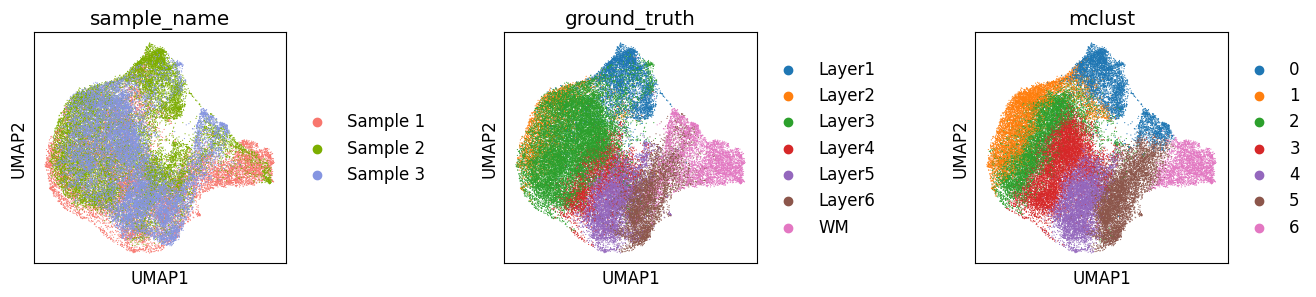

In [21]:
sc.pp.neighbors(adata_concat, use_rep='STAligner', random_state=666)
sc.tl.umap(adata_concat, random_state=666)

sample_id = ['Sample 1', 'Sample 2', 'Sample 3']
sample_color = ['#f8766d', '#7cae00', '#8595e1']
sample_color_dict = dict(zip(sample_id, sample_color))
adata_concat.uns['sample_name_colors'] = [sample_color_dict[x] for x in adata_concat.obs.sample_name.cat.categories]

adata_concat.obs['mclust'] = pd.Series(STAligner.match_cluster_labels(adata_concat.obs['ground_truth'], adata_concat.obs['mclust'].values),
                                         index=adata_concat.obs.index, dtype='category')


import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams["figure.figsize"] = (3, 3)
plt.rcParams['font.size'] = 12
sc.pl.umap(adata_concat,color=['sample_name','ground_truth','mclust'],ncols=3,wspace=0.7,show=True)

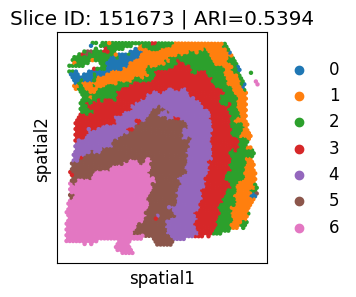

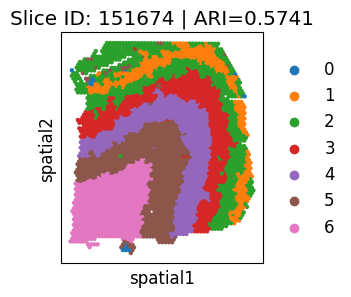

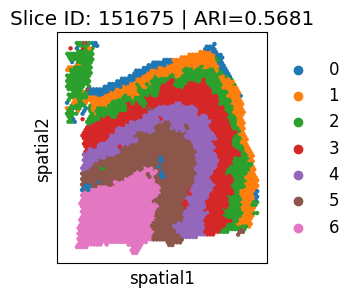

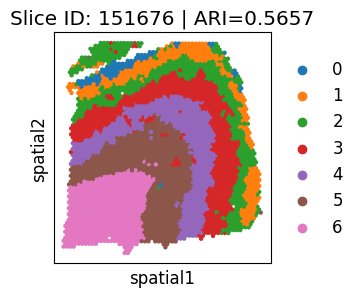

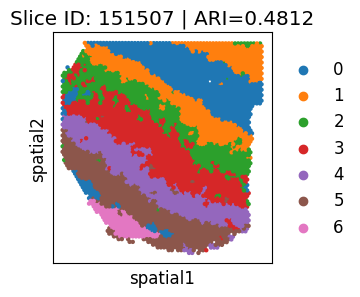

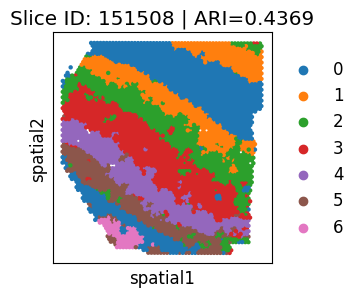

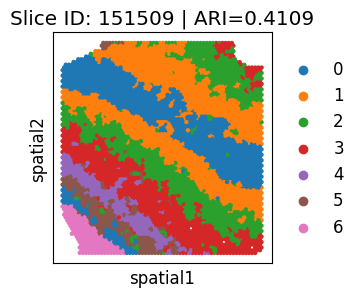

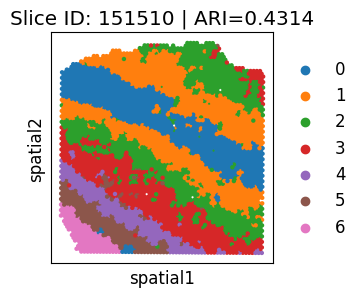

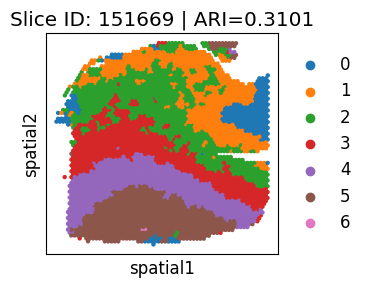

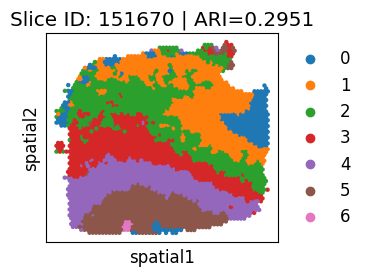

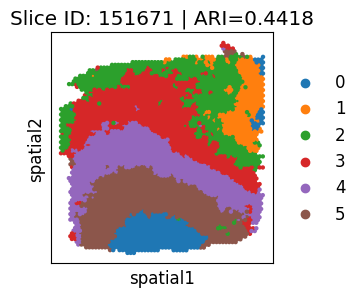

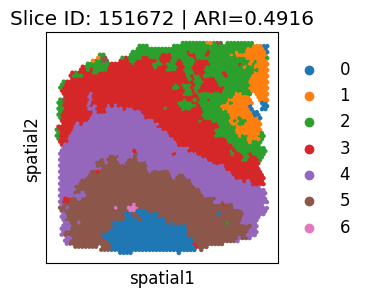

In [33]:
## plot clustering result for individual samples
import logging
import matplotlib.font_manager

# Set the font manager logger to suppress findfont warnings
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)

from sklearn import metrics
for slice_id in section_ids:
    adata = adata_concat[adata_concat.obs['slice_name'] == slice_id]
    adata.obsm['spatial'][:, 1] = -1 * adata.obsm['spatial'][:, 1]
    ARI = metrics.adjusted_rand_score(adata.obs['mclust'], adata.obs['ground_truth'])
    adata.uns['ARI'] = ARI
    ax=sc.pl.embedding(adata,
                    basis="spatial",
                    color="mclust",
                    size=40,
                    show=False,
                    title=f'Slice ID: {slice_id} | ARI={ARI:.4f}')
    ax.set_aspect('equal', 'box')
    plt.show()
    plt.close()